In [1]:
import os, sys
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

from fastai2.basics import *
from fastai2.vision.all import *

### Setup

In [2]:
path = untar_data(URLs.MNIST_TINY)

In [3]:
df = pd.DataFrame({'fn':[],'y':[]})

for digit_cat in os.listdir(path/'train'):
    
    tmp = [f'/train/{digit_cat}/{e}' for e in 
           os.listdir(path/'train'/str(digit_cat))] 
    df_tmp = pd.DataFrame({'fn': tmp})
    df_tmp['y'] = digit_cat
    df = pd.concat((df, df_tmp))
    
df['y'] = df['y'].astype('float')
df.reset_index(inplace=True)

In [4]:
def point_from_img(fn):

    img_np = np.array(Image.open(str(path) + fn))

    img_bool =         np.where(img_np > 0, 1, 0)
    row_sums =         img_bool.argmax(axis=1)
    binary_row_sums =  np.where(row_sums > 0, 1, 0)
    top_row_index =    binary_row_sums.tolist().index(1)
    top_row_values =   img_np[top_row_index,:]
    leftmost_index =   (top_row_values > 0).tolist().index(True)


    return (top_row_index, leftmost_index)

vals = [point_from_img(e) for e in df['fn']]
df_p = pd.DataFrame(vals, columns=['py','px'])
df = pd.concat((df,df_p ), axis=1)

In [5]:
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), PointBlock), 
                  splitter=RandomSplitter(),
                   get_x=ColReader('fn', pref=path),
                   get_y=ColReader(['px', 'py'])
                  )

dls = dblock.dataloaders(df)

### Figure Helper Funcs

In [24]:
def resid_figs(preds):
    
    predicts = preds[0]
    predicts_x, predicts_y = predicts[:,0], predicts[:,1]

    actuals = preds[1].view(-1,2)
    actuals_x, actuals_y = actuals[:,0], actuals[:,1]

    resids = predicts - actuals
    resids_x = resids.view(-1,2)[:,0]
    resids_y = resids.view(-1,2)[:,1]

    fig, ax = plt.subplots(1,2,figsize=(10,5))

    ax[0].scatter(preds[0][:, 0], preds[0][:, 1], c='g', alpha=0.4)
    ax[0].scatter(preds[1].view(-1,2)[:, 0], preds[1].view(-1,2)[:, 1], c='b', alpha=0.4)
    ax[0].legend(['predicted', '\nactual\n'])
    ax[0].set_title('Predicted vs Actual')

    ax[1].scatter(resids_x, resids_y, alpha=0.6);
    ax[1].vlines(0, min(resids_y), max(resids_y), linestyle='--');
    ax[1].hlines(0, min(resids_x), max(resids_x), linestyle='--');
    ax[1].set_title('Residuals Coords');

In [142]:
def resid_figs_models(l_preds, model_names=None):
    
    N = len(l_preds)

    if model_names is None:
        model_names = [f'model_{i}' for i in range(N)]
    
    predicts               = [None for _ in range(N)]
    predicts_x, predicts_y = [None for _ in range(N)],[None for _ in range(N)]
    actuals                = [None for _ in range(N)]
    actuals_x, actuals_y   = [None for _ in range(N)], [None for _ in range(N)]
    resids                 = [None for _ in range(N)]
    resids_x, resids_y     = [None for _ in range(N)], [None for _ in range(N)]
    
    for i, preds in enumerate(l_preds):
        
        predicts[i] = preds[0]
        predicts_x[i], predicts_y[i] = predicts[i][:,0], predicts[i][:,1]

        actuals[i] = preds[1].view(-1,2)
        actuals_x[i], actuals_y[i] = actuals[i][:,0], actuals[i][:,1]

        resids[i] = predicts[i] - actuals[i]
        resids_x[i] = resids[i].view(-1,2)[:,0]
        resids_y[i] = resids[i].view(-1,2)[:,1]
    
    model_colors = ['blue', 'red', 'green', 'pink']
    fig, ax = plt.subplots(1,2,figsize=(10,5))

    ax[0].scatter(actuals_x[0], actuals_y[0], c='black')
    legend = ['actual']
    for i, model_name in enumerate(model_names):
        
        ax[0].scatter(predicts_x[i], predicts_y[i], 
                      color=model_colors[i], alpha=0.4)
        legend += [model_name]
    
    ax[0].legend(legend)
    ax[0].set_title('Predicted vs Actual')

    for i, model_name in enumerate(model_names):
        ax[1].scatter(resids_x[i], resids_y[i], alpha=0.2);
    ax[1].vlines(0, *ax[1].get_ylim(), linestyle='--');
    ax[1].hlines(0, *ax[1].get_xlim(), linestyle='--');
    ax[1].set_title('Residuals Coords');
    
    ax[1].legend(legend[1:]);

### Load Trained Models /  Model-Stages

In [111]:
!ls ./models/

ft-4b.pth  hql.pth  mnist4-1.pth  mnist4-2.pth	mnist4-3.pth


In [112]:
model_stages = [('m1-epoch50', 'mnist4-1'),
                ('m1-epoch70', 'mnist4-2'),
                ('m1-epoch90', 'mnist4-3'),
               ]

loaded_learners =[]
for model_name, model_pth in model_stages:
    learn = cnn_learner(dls, resnet18, pretrained=True, y_range=(-1.,1.))
    learn.load(model_pth)
    loaded_learners.append(learn)

In [146]:
l_preds = [l.get_preds() for l in loaded_learners]

In [147]:
model_names = [e[0] for e in model_stages]

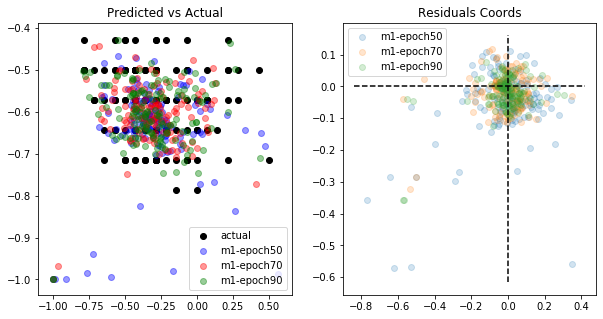

In [148]:
resid_figs_models(l_preds, model_names)

In [150]:
model_pth = 'mnist4-3'
learn = cnn_learner(dls, resnet18, pretrained=True, y_range=(-1.,1.))
learn.load(model_pth)

In [152]:
preds = learn.get_preds()
len(preds[0])

141

In [163]:
y_train = tensor([])
for _x, _y in dls.train:
    y_train = torch.cat((y_train, _y.view(-1,2)))
y_mean_train = y_train.mean(dim=0)
y_mean_train

tensor([-0.2949, -0.5891])

In [165]:
y_mean_pred = tensor([[y_mean_train.tolist()] for _ in range(len(preds[0]))])
len(y_mean_pred)

141

best model: 


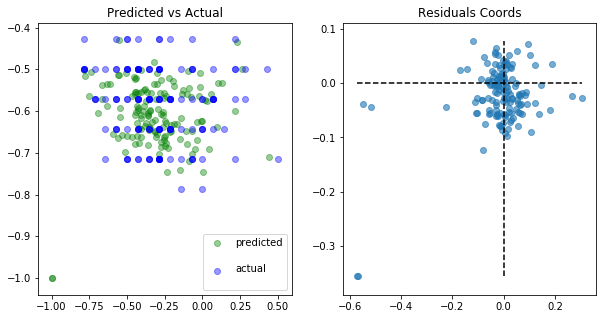

In [159]:
print('best model: ')
resid_figs(preds)

In [167]:
print('best model: ')
resid_figs((y_mean_pred, preds[1]))

best model: 


IndexError: index 1 is out of bounds for dimension 1 with size 1